In [9]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
def parse_collision_boxes(urdf_file):
    # Parse the URDF file
    tree = ET.parse(urdf_file)
    root = tree.getroot()

    boxes = []
    
    for link in root.findall("link"):
        for collision in link.findall("collision"):
            geometry = collision.find("geometry")
            box = geometry.find("box")
            if box is not None:
                size = list(map(float, box.attrib["size"].split()))
                origin_elem = collision.find("origin")
                if origin_elem is not None:
                    origin = list(map(float, origin_elem.attrib["xyz"].split()))
                    rpy = list(map(float, origin_elem.attrib["rpy"].split()))
                else:
                    origin = [0.0, 0.0, 0.0]
                    rpy = [0.0, 0.0, 0.0]
                boxes.append((size, origin, rpy))
    return boxes

def compute_min_max(size, origin, rpy):
    # Unpack size and origin
    sx, sy, sz = size
    ox, oy, oz = origin
    
    # Half extents
    hx, hy, hz = sx / 2, sy / 2, sz / 2
    
    # Define corners of the box relative to origin
    corners = np.array([
        [-hx, -hy, -hz],
        [-hx, -hy, hz],
        [-hx, hy, -hz],
        [-hx, hy, hz],
        [hx, -hy, -hz],
        [hx, -hy, hz],
        [hx, hy, -hz],
        [hx, hy, hz],
    ])
    
    # Rotation matrix for z-axis only (rpy[2])
    theta = rpy[2]
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    # Rotate and translate corners
    transformed_corners = np.dot(corners, rotation_matrix.T) + np.array([ox, oy, oz])
    
    # Get min and max
    min_coords = transformed_corners.min(axis=0)
    max_coords = transformed_corners.max(axis=0)
    
    return min_coords, max_coords

In [10]:
urdf_file = "model.urdf"
boxes = parse_collision_boxes(urdf_file)

global_min = np.array([float('inf'), float('inf'), float('inf')])
global_max = np.array([-float('inf'), -float('inf'), -float('inf')])

mins = []
maxs = []
for size, origin, rpy in boxes:
    min_coords, max_coords = compute_min_max(size, origin, rpy)
    mins.append(min_coords)
    maxs.append(max_coords)
    #print(f"Box: Size={size}, Origin={origin}, RPY={rpy}")
    #print(f"  Min: {min_coords}")
    #print(f"  Max: {max_coords}")
    
    # Update global bounds
    global_min = np.minimum(global_min, min_coords)
    global_max = np.maximum(global_max, max_coords)

print("\nGlobal Bounds:")
print(f"  Global Min: {global_min.round(3)}")
print(f"  Global Max: {global_max.round(3)}")


Global Bounds:
  Global Min: [-2.275 -2.525  0.   ]
  Global Max: [2.275 2.025 0.3  ]


In [11]:
buffer=0.1
adjusted_min = np.array(mins) - buffer
adjusted_max = np.array(maxs) + buffer

In [12]:
# Function to create a 2D grid with coordinates
cell_size = 0.1  # Adjust for finer or coarser grids

# Calculate number of rows and columns
rows = int(np.ceil((global_max[1] - global_min[1]) / cell_size))
cols = int(np.ceil((global_max[0]- global_min[0]) / cell_size))

# Create a 2D grid of coordinates
node_grid = np.zeros((rows, cols, 2))  # 2 for x and y coordinates

# Fill the grid with node coordinates
for i in range(rows):
    for j in range(cols):
        x = global_min[0] + j * cell_size
        y = global_min[1] + i * cell_size
        node_grid[i, j] = [x, y]

print("Node Grid Dimensions:", node_grid.shape)  # Should be (rows, cols, 2)
print("Example Node at (0,0):", node_grid[0, 0])



Node Grid Dimensions: (46, 46, 2)
Example Node at (0,0): [-2.27501982 -2.52521898]


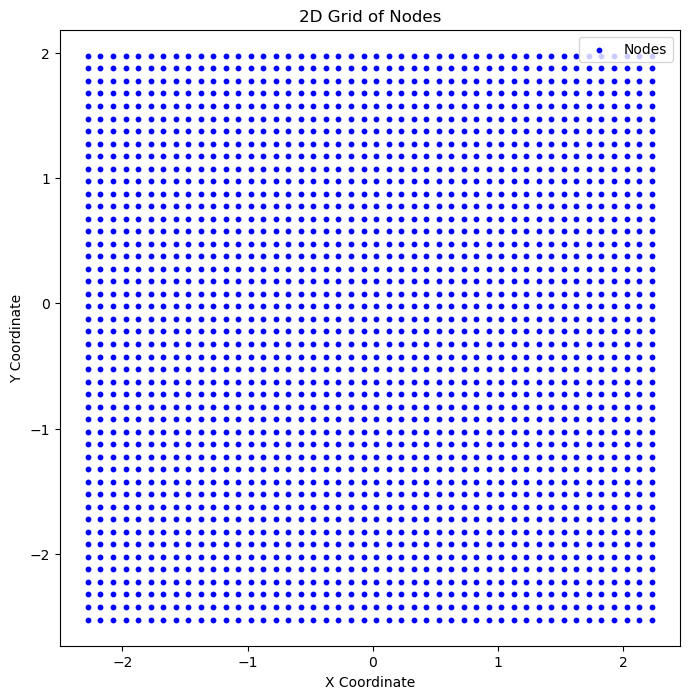

In [13]:
x_coords = node_grid[:, :, 0].flatten()
y_coords = node_grid[:, :, 1].flatten()

# Plot the grid of nodes
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, s=10, c='blue', label="Nodes")
plt.title("2D Grid of Nodes")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.axis("equal")
plt.legend()
plt.show()

In [14]:
def check_collision(coords):
    coords = np.array(coords)
    if coords.shape[0] == 2:
        coords = np.array(list(coords) + [0.1])
    for i in range(len(boxes)):
        if np.all((coords >= adjusted_min[i]) & (coords <= adjusted_max[i])):
            return True

    return False

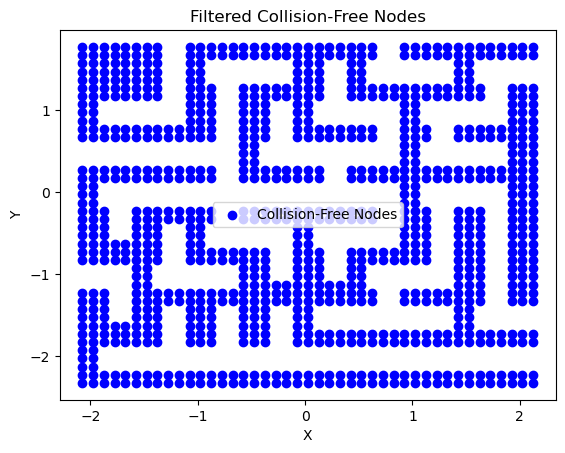

[[-2.07501982 -2.32521898]
 [-1.97501982 -2.32521898]
 [-1.87501982 -2.32521898]
 ...
 [ 1.92498018  1.77478102]
 [ 2.02498018  1.77478102]
 [ 2.12498018  1.77478102]]


In [18]:
collision_free_nodes=[]
for coord in node_grid.reshape(-1, 2):  # Flatten to a (N, 2) array
    if not check_collision(coord):  # If not in collision
        collision_free_nodes.append(tuple(coord))

collision_free_array = np.array(collision_free_nodes)
plt.scatter(collision_free_array[:, 0], collision_free_array[:, 1], label="Collision-Free Nodes", color="blue")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Filtered Collision-Free Nodes")
plt.show()

print(collision_free_array)


In [25]:
graph={}
for coord1 in collision_free_array:
    key = tuple(coord1)  # Use a tuple for the dictionary key
    neighbors = []  # Initialize the list for neighbors
    for coord2 in collision_free_array:
        if (coord1 != coord2).all:
            distance=np.linalg.norm(coord1-coord2)
            if distance<=np.sqrt(cell_size**2 + cell_size**2)+0.001:
                neighbors.append((coord2, distance))
    graph[key]=neighbors
            
            
print(graph[(-2.0750198209740227, -2.325218981918747)])
            
        

[(array([-2.07501982, -2.32521898]), 0.0), (array([-1.97501982, -2.32521898]), 0.09999999999999987), (array([-2.07501982, -2.22521898]), 0.10000000000000009), (array([-1.97501982, -2.22521898]), 0.14142135623730948)]
